# **All required libraries**

In [14]:
import numpy as np 
import pandas as pd
import os
import gensim
import nltk as nl
from sklearn.feature_extraction import text
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
# from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# **Load Datasets**

In [15]:
#Read Dataset
Headlines = pd.read_csv('dataset/abcnews-date-text.csv', usecols =["headline_text"]).dropna()
Headlines1 = pd.read_csv('dataset/fake.csv', usecols =["title"]).dropna()
# Headlines2 = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv', usecols =["title"]).dropna()

In [16]:
#Removing duplicated headlines
Headlines = Headlines.drop_duplicates('headline_text')
Headlines1 = Headlines1.drop_duplicates('title')
# Headlines2 = Headlines2.drop_duplicates('title')

In [17]:
#Rename dataframe columns and Combine all datasets
Headlines1 = Headlines1.rename(columns={'title': 'headline_text'})
# Headlines2 = Headlines2.rename(columns={'title': 'headline_text'})

# **Labelling**

In [18]:
#Creating lable for datasets
#million-headlines dataset will be used as real headlines
#fake-and-real-news-dataset & fake-news dataset will be used as fake headlines
Headlines['fake'] = 0
Headlines1['fake'] = 1
# Headlines2['fake'] = 1

# **Combine Datasets**

In [19]:
#Downsize million-headlines dataset to first 50K rows
data = pd.concat([Headlines[:50000],Headlines1])
print('Training dataset contains: {} Real headlines and {} Fake headlines.'.format(50000,len(Headlines1)))
data.to_csv('Combined_headlines.csv', index=False)

Training dataset contains: 50000 Real headlines and 11698 Fake headlines.


# **Data Preprocessing**

In [20]:
nl.download("stopwords", download_dir='./nltk_data')
nl.download("punkt", download_dir='./nltk_data')


nltk_stopwords = nl.corpus.stopwords.words('english')
gensim_stopwords = gensim.parsing.preprocessing.STOPWORDS
sklearn_stopwords = text.ENGLISH_STOP_WORDS
combined_stopwords = sklearn_stopwords.union(nltk_stopwords,gensim_stopwords)

[nltk_data] Downloading package stopwords to ./nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to ./nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
print('NLTK has {} stop words'.format(len(nltk_stopwords)))
print('Gensim has {} stop words'.format(len(gensim_stopwords)))
print('Sklearn has {} stop words'.format(len(sklearn_stopwords)))
print('Combined stopwords list has {} stop words'.format(len(combined_stopwords)))

NLTK has 179 stop words
Gensim has 337 stop words
Sklearn has 318 stop words
Combined stopwords list has 390 stop words


In [22]:
porter_stemmer = PorterStemmer() 

In [23]:
data['headline_text'] = data['headline_text'].apply(lambda x: x.lower())
data['headline_text'] = data['headline_text'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
data['headline_text'] = data['headline_text'].apply(lambda x: ' '.join([porter_stemmer.stem(word) for word in x.split()]))
data['headline_text'] = data['headline_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (combined_stopwords)]))

# **Splitting Dataset**

In [24]:
x_train,x_test,y_train,y_test=train_test_split(data['headline_text'], data['fake'], test_size=0.2, random_state=7)

# **Construct models with TF-IDF**

In [25]:
tfidf_vectorizer = TfidfVectorizer(tokenizer = word_tokenize, max_features = 300)
tfidf_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_test = tfidf_vectorizer.transform(x_test)
tfidf_combine = np.vstack([tfidf_train.todense(), tfidf_test.todense()])
tfidf_features = tfidf_vectorizer.get_feature_names_out()

C:\Users\borisPMC\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# **1.1 Different Basic Model Overview**

**1.Decision Tree**

In [26]:
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model.fit(tfidf_train, y_train)
y_pred_dt = dt_model.predict(tfidf_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy of the Decision Tree model: {accuracy_dt * 100:.2f}%")

Accuracy of the Decision Tree model: 85.21%


**2.Random Forest Classifier**

In [27]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf_model.fit(tfidf_train, y_train)
y_pred_rf = rf_model.predict(tfidf_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy of the Random Forest model: {accuracy_rf * 100:.2f}%")

Accuracy of the Random Forest model: 81.27%


**3.k-Nearest Neighbors (kNN)**

In [28]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(tfidf_train, y_train)
y_pred = knn_model.predict(tfidf_test)
accuracy_kNN = accuracy_score(y_test, y_pred)
print(f"Accuracy of the kNN model: {accuracy_kNN * 100:.2f}%")

Accuracy of the kNN model: 80.23%


**4.Support Vector Classifier (SVC)**

In [29]:
svc_model = SVC(kernel='linear', C=1, random_state=42)
svc_model.fit(tfidf_train, y_train)
y_pred = svc_model.predict(tfidf_test)
accuracy_SVC = accuracy_score(y_test, y_pred)
print(f"Accuracy of the SVC model: {accuracy_SVC * 100:.2f}%")

Accuracy of the SVC model: 87.63%


**5.Naive Bayesiian Model**

In [30]:
nb_model = MultinomialNB()
nb_model.fit(tfidf_train, y_train)
y_pred = nb_model.predict(tfidf_test)
accuracy_nb = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Naive Bayes model: {accuracy_nb * 100:.2f}%")


Accuracy of the Naive Bayes model: 88.03%


**6.Logistic Regression Model**

In [31]:
# Initialize the Logistic Regression Model
log_reg = LogisticRegression(C=1.0, penalty='none', solver='newton-cg', random_state=42)

# Train the model
log_reg.fit(tfidf_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(tfidf_test)

# Evaluate the model
accuracy_log = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_log:.2f}")
print(classification_report(y_test, y_pred))

C:\Users\borisPMC\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      9997
           1       0.87      0.44      0.58      2343

    accuracy                           0.88     12340
   macro avg       0.87      0.71      0.76     12340
weighted avg       0.88      0.88      0.86     12340



**Basic Model Performance Summary**

In [32]:
print("\nModel Performance Summary:")
print(f"{'Model':<20} {'Accuracy':>10}")
print("-" * 30)
print(f"{'Decision Tree:':<25}{accuracy_dt * 100:.2f}%")
print(f"{'Random Forest:':<24} {accuracy_rf * 100:.2f}%")
print(f"{'kNN:':<24} {accuracy_kNN * 100:.2f}%")
print(f"{'SVC:':<24} {accuracy_SVC * 100:.2f}%")
print(f"{'Naive Bayes:':<24} {accuracy_nb * 100:.2f}%")
print(f"{'Logistic Regression:':<24} {accuracy_log * 100:.2f}%")


Model Performance Summary:
Model                  Accuracy
------------------------------
Decision Tree:           85.21%
Random Forest:           81.27%
kNN:                     80.23%
SVC:                     87.63%
Naive Bayes:             88.03%
Logistic Regression:     88.03%


# **1.2Random Sampling from TFIDF_train (with label) set with different models**

In [33]:
# Split n sets of label-balanced data
def get_random_sample_sets(df, n=100, k=5000):
    def find_news(label):
        df_found = df[df["fake"] == label]
        df_sample = df_found.sample(k)
        return df_sample

    def random_samples():
        true_news = find_news(0)
        fake_news = find_news(1)
        concat_df = pd.concat((true_news, fake_news), axis=0)
        
        # Shuffle only once before splitting
        shuffled_df = concat_df.sample(frac=1)
        
        return shuffled_df

    random_sample_sets = [random_samples() for _ in range(n)]
    return random_sample_sets

Prepare Balanced Samples and Base Model

In [34]:
population_set = pd.concat((pd.DataFrame(tfidf_combine), pd.concat((y_train, y_test)).reset_index(drop=True)), axis=1)
random_sample_set = get_random_sample_sets(population_set, 1, 11000)

dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5)
svc_model = SVC(kernel='linear', C=1, random_state=42)
nb_model = MultinomialNB()
lr_model = LogisticRegression(C=1.0, penalty='none', solver='newton-cg', random_state=42)

Evaluate model performance with balanced dataset by cross-validation

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      9952
           1       1.00      0.22      0.36      2388

    accuracy                           0.85     12340
   macro avg       0.92      0.61      0.64     12340
weighted avg       0.87      0.85      0.81     12340



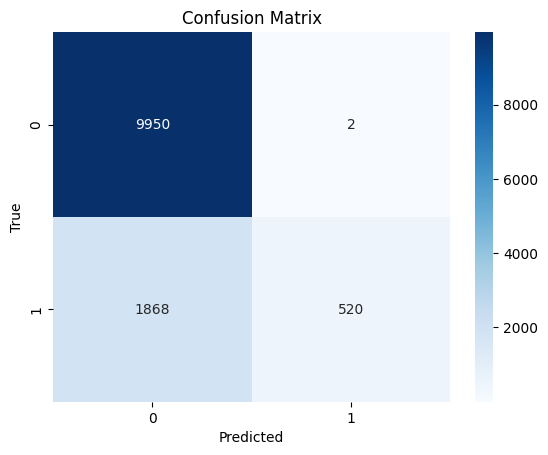

              precision    recall  f1-score   support

           0       0.56      1.00      0.72      2204
           1       1.00      0.22      0.35      2196

    accuracy                           0.61      4400
   macro avg       0.78      0.61      0.54      4400
weighted avg       0.78      0.61      0.54      4400



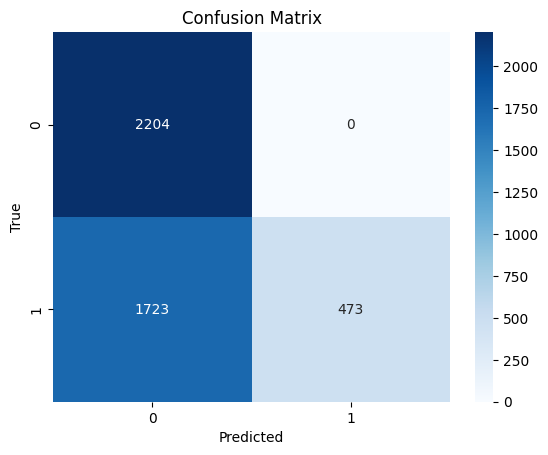

In [35]:
def cross_validation_balance(df):

    Y = random_sample_set[0]["fake"]
    X = random_sample_set[0].drop("fake",axis=1)

    dt_accuracy = cross_val_score(dt_model, X, Y, cv=5, scoring="accuracy")
    rf_accuracy = cross_val_score(rf_model, X, Y, cv=5, scoring="accuracy")
    knn_accuracy = cross_val_score(knn_model, X, Y, cv=5, scoring="accuracy")
    svc_accuracy = cross_val_score(svc_model, X, Y, cv=5, scoring="accuracy")
    nb_accuracy = cross_val_score(nb_model, X, Y, cv=5, scoring="accuracy")
    lr_accuracy = cross_val_score(lr_model, X, Y, cv=5, scoring="accuracy")
    print(f"Cross-validation scores: {dt_accuracy}")
    print(f"Average cross-validation score: {np.mean(dt_accuracy)}")

    print("\nModel Average Performance Summary:")
    print(f"{'Model':<20} {'Accuracy':>10}")
    print("-" * 30)
    print(f"{'Decision Tree:':<25}{np.mean(dt_accuracy) * 100:.2f}%")
    print(f"{'Random Forest:':<24} {np.mean(rf_accuracy) * 100:.2f}%")
    print(f"{'kNN:':<24} {np.mean(knn_accuracy) * 100:.2f}%")
    print(f"{'SVC:':<24} {np.mean(svc_accuracy) * 100:.2f}%")
    print(f"{'Naive Bayes:':<24} {np.mean(nb_accuracy) * 100:.2f}%")
    print(f"{'Logistic Regression:':<24} {np.mean(lr_accuracy) * 100:.2f}%")

def confusion_predict(model, df):

    # df: balanced df set
    Y = df["fake"]
    X = df.drop("fake",axis=1)

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    # Print classification report
    print(classification_report(y_test, y_pred))  # Corrected to use y_test

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

confusion_predict(dt_model, population_set)
confusion_predict(dt_model, random_sample_set[0])

# **2.1 Create a confusion matrix graph with PCA and logistic Regression**

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      2204
           1       0.76      0.77      0.76      2196

    accuracy                           0.76      4400
   macro avg       0.76      0.76      0.76      4400
weighted avg       0.76      0.76      0.76      4400



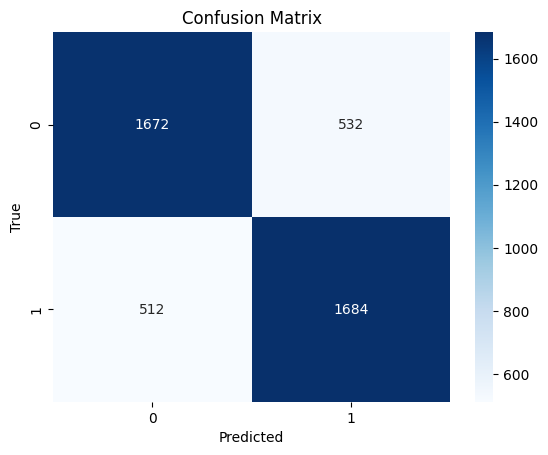

In [36]:
# Create a pipeline with PCA and logistic regression

# Convert sparse matrix to dense array
df = random_sample_set[0]
Y = df["fake"]
X = df.drop("fake",axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

# Define the pipeline
pipeline = Pipeline([
    ('pca', PCA(n_components=100)),  # Adjust n_components based on your data
    ('logistic_regression', KNeighborsClassifier(n_neighbors=5, n_jobs = -1))
])

# Fit the pipeline
pipeline.fit(x_train, y_train)

# Predict on the test set
predictions = pipeline.predict(x_test)

# Print classification report
print(classification_report(y_test, predictions))  # Corrected to use y_test

# Plot confusion matrix
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# # Perform 5-fold cross-validation
# scores = cross_val_score(pipeline, x_train, y_train, cv=5, scoring='accuracy')
# print(f"Cross-validation scores: {scores}")
# print(f"Average cross-validation score: {np.mean(scores)}")

# **2.2 Logistic Regression Classifier- Randomized Search**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform
from random import randint

# Define the hyperparameter distributions for logistic regression

def get_rand_lr_model():
    
    param_dist = {
        'C': uniform(0.001, 999),  # Uniform distribution between 0.001 and 1000
        'penalty': ['l1', 'l2'],  # Lasso or Ridge regularization
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algorithm to use in the optimization problem
        'max_iter': [randint(10, 100) for _ in range(5)],  # Discrete integer distribution for max_iter
        'class_weight': ['balanced', None]  # Class weights
    }
    
    # Initialize the Logistic Regression model
    lr = LogisticRegression(random_state=42)

    # Define Grid Search
    rand_search_lr = RandomizedSearchCV(
        estimator=lr,
        param_distributions=param_dist,
        n_iter=50,  # Number of parameter settings that are sampled
        cv=5,  # Number of cross-validation folds
        verbose=2,  # Controls the verbosity: the higher, the more messages
        random_state=42,  # For reproducibility
        n_jobs=-1  # Use all processors
    )
    return rand_search_lr # untrained model

def get_rand_knn_model():

    param_list_knn = {
        "n_neighbors": [k*2+1 for k in range(50)]
    }

    # Initialize the Logistic Regression model    
    knn = KNeighborsClassifier()

    rand_search_knn = RandomizedSearchCV(
        estimator=knn,
        param_distributions=param_list_knn,
        n_iter=50,  # Number of parameter settings that are sampled
        cv=5,  # Number of cross-validation folds
        verbose=2,  # Controls the verbosity: the higher, the more messages
        random_state=42,  # For reproducibility
        n_jobs=-1  # Use all processors
    )

    return rand_search_knn

# Fit the model to the data
rand_search_lr = get_rand_lr_model()
rand_search_lr.fit(x_train, y_train)
rand_search_knn = get_rand_knn_model()
rand_search_knn.fit(x_train, y_train)

# Access the best model and its hyperparameters
best_lr = rand_search_lr.best_estimator_
print('Best hyperparameters:', rand_search_lr.best_params_)

best_knn = rand_search_knn.best_estimator_
print('Best hyperparameters:', rand_search_knn.best_params_)

confusion_predict(best_lr, random_sample_set[0])
confusion_predict(best_knn, random_sample_set[0])

# **2.3 Logistic Regression Classifier- Grid Search**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

def get_grid_lr_model():

    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Regularization parameter
        'penalty': ['l1', 'l2'],  # Lasso or Ridge regularization
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Optimization algorithm
        'max_iter': [100, 200, 300]  # Maximum number of iterations
    }
    log_reg = LogisticRegression(random_state=42)
    grid_search_lr = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
    return grid_search_lr

def get_grid_knn_model():

    param_list_knn = {
        "n_neighbors": [k*2+1 for k in range(50)]
    }
    knn = KNeighborsClassifier()
    grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_list_knn, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
    return grid_search_knn

# Step 5: Fit the GridSearchCV object to the training data
grid_search_lr = get_grid_lr_model()
grid_search_lr.fit(x_train, y_train)
grid_search_knn = get_grid_knn_model()
grid_search_knn.fit(x_train, y_train)

# Step 6: Retrieve the best parameters and evaluate the model on the test set
best_lr = grid_search_lr.best_estimator_
best_knn = grid_search_knn.best_estimator_

confusion_predict(best_lr, random_sample_set[0])
confusion_predict(best_knn, random_sample_set[0])

# **2.4 Ensemble Model**

In [ ]:
# Base method for bagging model
def train_model(base_model, sample_set: pd.DataFrame):

    Y = sample_set["fake"]
    X = sample_set.drop("fake", axis=1)

    base_model.fit(X, Y)
    return base_model

def bagging_pred(model_set, test_set: pd.DataFrame):

    def model_pred(model, test_set: pd.DataFrame):
        y_pred = model.predict(test_set)
        return y_pred
    
    def vote(row: pd.Series):
        vote_result = row.mode()
        return vote_result

    Y = test_set["fake"]
    X = test_set.drop("fake", axis=1)

    def map_confusion(y_true, y_pred):
        # Print classification report
        print(classification_report(y_true, y_pred))  # Corrected to use y_test

        # Plot confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    predictions = []
    # Collect predictions in a list. Iterated by models
    for k in range(len(model_set)):
        pred = model_pred(model_set[k], X)
        predictions.append(pred)

    pred_result = pd.DataFrame(predictions)
    # Apply the voting function to each row
    vote_result = pred_result.apply(vote, axis=0).iloc[0]
    score = map_confusion(Y, vote_result)
    return score

# Fine-tuned LogReg model
base_model = LogisticRegression(C=1, max_iter=100, penalty="l2", solver="newton-cg")
base_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# 100 models for bagging
random_sample_set_list = get_random_sample_sets(population_set, 100, 10000)
model_list = [train_model(base_model, random_sample_set_list[k]) for k in range(len(random_sample_set_list)-1)]

# Use last sample set as testing case
print(bagging_pred(model_list, random_sample_set_list[-1]))

# **Final Implementation: Random Sample + Grid Search + Ensemble on Logistic Regression**

In [ ]:
# Base method for bagging model
def train_grid_model(grid_model, sample_set: pd.DataFrame):

    Y = sample_set["fake"]
    X = sample_set.drop("fake", axis=1)

    grid_model.fit(x_train, y_train)

    # Retrieve the best parameters and evaluate the model on the test set
    best_lr = grid_search_lr.best_estimator_
    return best_lr

grid_model = get_grid_lr_model()

# 100 models for bagging
random_sample_set_list = get_random_sample_sets(population_set, 100, 10000)
model_list = [train_grid_model(grid_model, random_sample_set_list[k]) for k in range(len(random_sample_set_list)-1)]

# Use last sample set as testing case
bagging_pred(model_list, random_sample_set_list[-1])